In [1]:
import math, random
import gym
import numpy as np
import sys
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
sys.path.append('../')
from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch

In [5]:
env_id = "ChopperCommand-v0"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

<h3>Use Cuda</h3>

In [6]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

<h2>Replay Buffer</h2>

In [7]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, next_q_value, next_e_value, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, next_q_value, next_e_value, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, next_q_value, next_e_value, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), next_q_value, next_e_value, done
    
    def __len__(self):
        return len(self.buffer)

<h2>Epsilon greedy exploration</h2>

In [8]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

<h2>Computing Temporal Difference Loss</h2>

In [9]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, next_q_value, next_e_value, done = replay_buffer.sample(batch_size)
    
    e_reward = torch.zeros([batch_size])
    e_reward = Variable(torch.FloatTensor(e_reward))
        
    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))
    

    q_values      = q_model(state)
    next_q_values = q_model(next_state)
    
    e_values      = e_model(state)
    next_e_values = e_model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    #next_q_value     = next_q_values.max(1)[0]
    next_q_value = Variable(torch.FloatTensor(np.array(next_q_value)))
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    e_value          = e_values.gather(1, action.unsqueeze(1)).squeeze(1)
    #next_e_value     = next_e_values.max(1)[0]
    next_e_value = Variable(torch.FloatTensor(np.array(next_e_value)))
    expected_e_value = e_reward + gamma * next_e_value * (1 - done)
    
    q_loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
    e_loss = (e_value - Variable(expected_e_value.data)).pow(2).mean()


        
    q_optimizer.zero_grad()
    q_loss.backward()
    q_optimizer.step()
    
    e_optimizer.zero_grad()
    e_loss.backward()
    e_optimizer.step()
    
    return q_loss, e_loss

In [10]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<p><hr></p>

<h1>Atari Environment</h1>

In [11]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions, is_Evalue):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        if is_Evalue:
            self.shift = 10
        else:
            self.shift = 0
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = torch.add(x, self.shift)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action
    
    def predict(self, state):
        state = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
        q_value = self.forward(state)
        return q_value

In [12]:
q_model = CnnDQN(env.observation_space.shape, env.action_space.n, False)
e_model = CnnDQN(env.observation_space.shape, env.action_space.n, True)
if USE_CUDA:
    q_model = q_model.cuda()
    e_model = e_model.cuda()
    
q_optimizer = optim.Adam(q_model.parameters(), lr=1e-2)
e_optimizer = optim.Adam(e_model.parameters(), lr=1e-2)

replay_initial = 100
replay_buffer = ReplayBuffer(100000)

In [13]:
state = env.reset()
np.mean(q_model.predict(state).data.cpu().numpy()[0])
q_model.predict(state)

Variable containing:

Columns 0 to 9 
-1.9935 -1.2379 -2.3559 -1.4497  0.6078  0.3414 -0.7361  1.2708  1.5194  6.6176

Columns 10 to 17 
-2.2838  0.2987 -0.3070  0.2339  0.8272  1.1129 -0.6375  0.9839
[torch.cuda.FloatTensor of size 1x18 (GPU 0)]

In [14]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

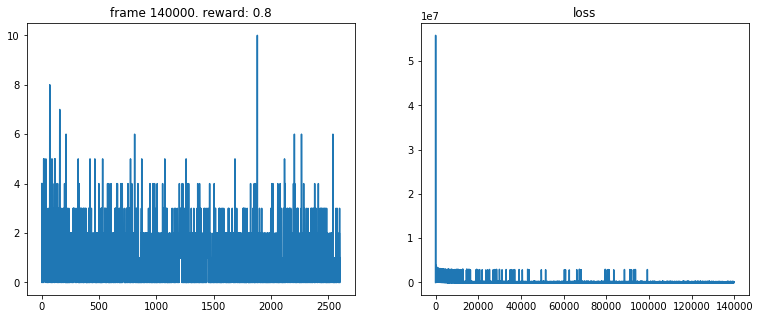

In [ ]:
num_frames = 3000000
batch_size = 32
gamma      = 0.99

q_losses = []
e_losses = []
all_rewards = []
episode_reward = 0


state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = q_model.act(state, epsilon)
    q_values = q_model.predict(state)
    
    
    next_state, reward, done, _ = env.step(action)
    next_action = q_model.act(next_state, 0)
    next_q_value = q_model.predict(next_state).data.cpu().numpy()[0][next_action]
    next_e_value = e_model.predict(next_state).data.cpu().numpy()[0][next_action]


    replay_buffer.push(state, action, reward, next_state, next_q_value, next_e_value, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        q_loss, e_loss = compute_td_loss(batch_size)
        q_losses.append(q_loss.data[0])
        e_losses.append(e_loss.data[0])


        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, q_losses)

In [52]:
state = env.reset()

In [54]:
q_model.predict(state)

Variable containing:

Columns 0 to 9 
 4.5785  4.0957  4.4388  3.8170  4.1004  3.9210  3.8433  4.4064  3.8940  4.3663

Columns 10 to 17 
 4.2429  3.8675  3.9207  4.1498  4.4521  4.1238  4.4575  4.3523
[torch.cuda.FloatTensor of size 1x18 (GPU 0)]

In [15]:
len(q_trajectory)

14000

<Container object of 6 artists>

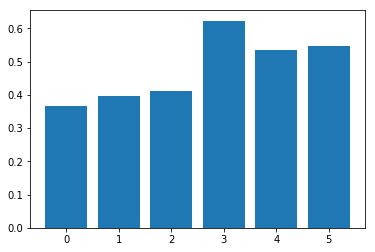

In [74]:
plt.bar(range(6), (q_trajectory[32][1].data[0]+1)/2)

In [17]:
q_values

Variable containing:

Columns 0 to 7 
 84.5538  81.7071  81.5424  83.1335  81.3604  81.9538  82.9058  82.1148

Columns 8 to 15 
 81.0860  83.0786  83.3791  83.9378  83.8134  84.3543  82.5718  83.4662

Columns 16 to 17 
 85.3304  84.6416
[torch.cuda.FloatTensor of size 1x18 (GPU 0)]